In [3]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
import os
import pickle as pk

#Prevent TensorFlow from taking up all of GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)
warnings.simplefilter('ignore', UserWarning)

from util import *

2022-04-29 08:32:18.701186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/extras/CUPTI/lib64
2022-04-29 08:32:18.701213: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[]


2022-04-29 08:32:20.027278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/extras/CUPTI/lib64
2022-04-29 08:32:20.027388: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/extras/CUPTI/lib64
2022-04-29 08:32:20.027455: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/extras/CUPTI/lib64
2022-04-29 08:32:20.027522: W tensorflow/stream_executor

In [3]:
# data_dim = 2
# data_size = 1000

# X2, X1, y2, y1, columns = generate_lipton(scale=True, num_pts=data_size)
# name1 = 'women'
# name2 = 'men'

read and whiten data

In [1]:
def whitenize(df_p, df_np):
    joint_df = pd.concat([df_p, df_np])
    for col in joint_df.columns:
        if col in []:
            print(col)
            df_p[col] = np.log(df_p[col] + 10e-6)
            df_np[col] = np.log(df_np[col] + 10e-6)
            joint_df[col] = np.log(joint_df[col] + 10e-6)
    means = joint_df.mean()
    discret = []
    for col in joint_df.columns:
        if len(np.unique(joint_df[col])) <= 2:
            discret.append(col)
    new_p_df = df_p - means
    new_np_df = df_np - means
    stds = joint_df.std()
    for col in joint_df.columns:
        if joint_df[col].std() > 0:
            new_p_df[col] = new_p_df[col] / joint_df[col].std()
            new_np_df[col] = new_np_df[col] / joint_df[col].std()
    return new_p_df, new_np_df, means, stds, discret

In [4]:
in_X1 = pd.read_csv("SSL_inputs_protec.csv")
in_X1.drop(columns=["Unnamed: 0"], inplace=True)
#in_X1.columns = list(range(len(in_X1.columns)))

in_X2 = pd.read_csv("SSL_inputs_notprotec.csv")
in_X2.drop(columns=["Unnamed: 0"], inplace=True)
#in_X2.columns = list(range(len(in_X2.columns)))
X1, X2, means, stds, discrets = whitenize(in_X1, in_X2)
X1 = X1[:500]
X2 = X2[:500]
X1 = X1.to_numpy()
X2 = X2.to_numpy()

In [5]:
data_dim = X1.shape[1]
name1 = 'non-white'
name2 = 'white'

In [6]:
data_dim

7

In [8]:
lambda_l1 = 1e-4

D, G, combined = create_gan_small(data_dim, trans_loss_func=squared_l1_loss, trans_loss_wt=lambda_l1)
#train(D, G, combined, X1, X2, name1, name2, xlabel='work_exp', ylabel='hair_len', xlim=(-3,3), ylim=(-3,3), epochs=2000, batch_size=32, xindex=0, yindex=4)

2022-04-29 08:33:01.815500: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#G.save_weights('ssl_gan')
G.load_weights('ssl_gan')

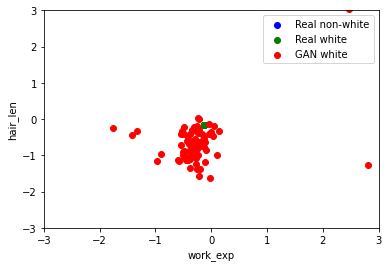

In [10]:
plot(X1, X2, G, name1, name2, num_pts_plot=200, xlabel='work_exp', ylabel='hair_len', xlim=(-3,3), ylim=(-3,3), xindex=1, yindex=2)

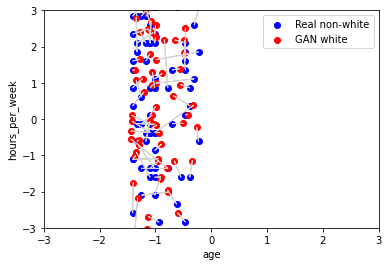

In [11]:
plot_changes(X1, G, name1, name2, xlabel='age', ylabel='hours_per_week', xlim=(-3,3), ylim=(-3,3), num_pts_plot=100, xindex=0, yindex=5)

In [13]:
def dewhiten(data, mu, sigma, dis):
    new_df = pd.DataFrame(data, columns = list(range(data.shape[1])))
    for col in new_df.columns:
        if sigma[col] > 0:
            new_df[col] = new_df[col] * sigma[col]
        new_df[col] = new_df[col] + mu[col]
    for col in new_df.columns:
        if col in []:
            print(col)
            new_df[col] = np.exp(new_df[col]) - 10e-6
        if str(col) in dis or col in [1, 2, 3, 4, 6]:
            new_df[col] = np.abs(np.round(new_df[col]))
    return new_df

In [52]:
dewhiten(G.predict(X1[[200]]), means, stds, discrets)

,0,1,2,3,4,5,6
0,12.827538,0.0,-0.0,3.0,0.0,1.385766,-0.0


In [14]:
dewhiten(G.predict(X1), means, stds, discrets)
dewhite_args = {'mu': means, 'sigma': stds, "dis": discrets}
with open("ssl_dwa.pk", 'wb') as f:
    pk.dump(dewhite_args, f)

In [8]:
yhat1 = model.predict(X1)
yhat2 = model.predict(X2)
Xfake = G.predict(X1)
yhat_fake2 = model.predict(Xfake)
print(yhat1.sum(), yhat_fake2.sum())

291 144
